UNO
====

**Less-to-More Generalization: Unlocking More Controllability by In-Context Generation**

 * Paper: https://arxiv.org/abs/2504.02160

![UNO Overview](../assets/uno_overview.png)


```bash
# installation
git clone https://github.com/bytedance/UNO.git
pip install -r requirements.txt
```

In [ ]:
import os
import sys
import dataclasses
from typing import Literal

from accelerate import Accelerator
from transformers import HfArgumentParser
from PIL import Image
import matplotlib.pyplot as plt

import itertools

sys.path.append("./UNO")
from uno.flux.pipeline import UNOPipeline, preprocess_ref


def horizontal_concat(images):
    widths, heights = zip(*(img.size for img in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in images:
        new_im.paste(img, (x_offset, 0))
        x_offset += img.size[0]

    return new_im


@dataclasses.dataclass
class InferenceArgs:
    prompt: str | None = None
    image_paths: list[str] | None = None
    eval_json_path: str | None = None
    offload: bool = False
    num_images_per_prompt: int = 3
    model_type: Literal["flux-dev", "flux-dev-fp8", "flux-schnell"] = "flux-dev-fp8"
    width: int = 256
    height: int = 256
    ref_size: int = -1
    num_steps: int = 25
    guidance: float = 4
    seed: int = 3407
    save_path: str = "output/inference"
    only_lora: bool = True
    concat_refs: bool = False
    lora_rank: int = 512
    data_resolution: int = 256
    pe: Literal['d', 'h', 'w', 'o'] = 'd'


accelerator = Accelerator()

# build model args:
parser = HfArgumentParser([InferenceArgs])
model_args = parser.parse_args_into_dataclasses(args=[])[0]

# load pipeline:
pipeline = UNOPipeline(
    model_args.model_type,
    accelerator.device,
    model_args.offload,
    only_lora=model_args.only_lora,
    lora_rank=model_args.lora_rank
)

pipeline

/home/pyml/anaconda3/envs/py311/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 13.27it/s]


Init AE
Init model
Loading lora
Loading main checkpoint
####
We are in fp8 mode right now, since the fp8 checkpoint of XLabs-AI/flux-dev-fp8 seems broken
we convert the fp8 checkpoint on flight from bf16 checkpoint
If your storage is constrainedyou can save the fp8 checkpoint and replace the bf16 checkpoint by yourself



In [2]:
import matplotlib.pyplot as plt


def inference(pipeline, image_paths, prompt):
    data_root = "./"
    data_dicts = [{"prompt": prompt, "image_paths": image_paths}]

    for (i, data_dict), j in itertools.product(
            enumerate(data_dicts),
            range(model_args.num_images_per_prompt)
        ):
        if (i * model_args.num_images_per_prompt + j) % accelerator.num_processes != accelerator.process_index:
            continue

        ref_imgs = [
            Image.open(os.path.join(data_root, img_path))
            for img_path in data_dict["image_paths"]
        ]
        if model_args.ref_size==-1:
            model_args.ref_size = 512 if len(ref_imgs)==1 else 320

        ref_imgs = [preprocess_ref(img, model_args.ref_size) for img in ref_imgs]

        image_gen = pipeline(
            prompt=data_dict["prompt"],
            width=model_args.width,
            height=model_args.height,
            guidance=model_args.guidance,
            num_steps=model_args.num_steps,
            seed=model_args.seed + j,
            ref_imgs=ref_imgs,
            pe=model_args.pe,
        )
        if model_args.concat_refs:
            image_gen = horizontal_concat([image_gen, *ref_imgs])

        plt.imshow(image_gen)
        plt.axis('off')
        plt.show()


100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


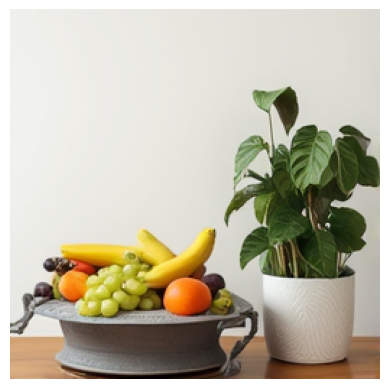

100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


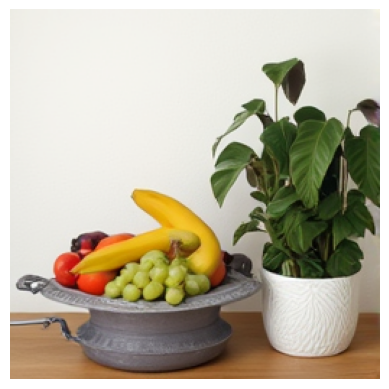

100%|██████████| 25/25 [00:11<00:00,  2.13it/s]


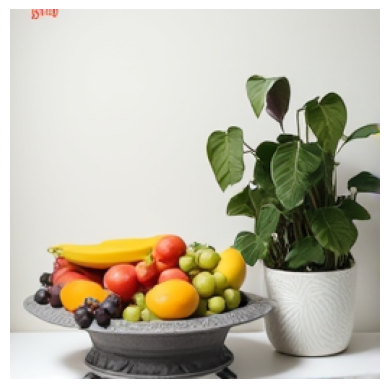

In [ ]:
image_paths = [
    "../samples/anchor_plant.jpg",
    "../samples/anchor_fruits.jpg",
]
prompt = "a photo of fruits basket next to a house plant"

inference(
    pipeline,
    image_paths=image_paths,
    prompt=prompt
)